## GENERAL SETUP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.planets import PlanetModel
from gallifrey.utilities.dataframe import rename_labels
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    contour_plot,
)

## PLOT SETUP

In [4]:
print(
    "RIDGE PLOT 1: ALL CATEGORIES AT ONE FIXED [FE/H] AND OTHER VARIABLES SAMPLED -> INTRINSIC VARIATIONS UNRELATED TO METALLICITY"
)
print(
    "ADD MODEL WHERE METALLICITIES BELOW -0.5 GET 0 PLANETS, SEE HOW MUCH THAT CHANGES (PHRASE IT AS TWO EXTREMES)"
)

RIDGE PLOT 1: ALL CATEGORIES AT ONE FIXED [FE/H] AND OTHER VARIABLES SAMPLED -> INTRINSIC VARIATIONS UNRELATED TO METALLICITY
ADD MODEL WHERE METALLICITIES BELOW -0.5 GET 0 PLANETS, SEE HOW MUCH THAT CHANGES (PHRASE IT AS TWO EXTREMES)


In [5]:
set_plot_defaults()
figure_directory = "Planet_model"

## REDUCING DIMENSIONALITY

In [6]:
num_samples = int(1e5)

num_embryos = 50
host_star_mass = 1

planet_model = PlanetModel(num_embryos)
population_id = planet_model.get_population_id(num_embryos, host_star_mass)

categories = [
    category
    for category in planet_model.categories
    if category not in ["Dwarf", "D-Burner"]
]
included_variables = ("log_initial_mass", "[Fe/H]")

### Creating Sample of included Monte Carlo Variables

In [7]:
bounds = {
    variable: planet_model.get_systems(population_id).bounds[variable]
    for variable in included_variables
}
samples = np.column_stack(
    [np.random.uniform(bound[0], bound[1], num_samples) for bound in bounds.values()]
)
samples = pd.DataFrame(samples, columns=bounds.keys())

### Compare behaviour of full and reduced model

In [8]:
prediction_parameter_dict = {
    "categories": categories,
    "host_star_mass": host_star_mass,
    "variables": samples,
    "return_full": False,
}

full_model = planet_model.prediction(**prediction_parameter_dict)
reduced_model = planet_model.prediction(
    **prediction_parameter_dict, included_variables=included_variables
)
model_difference = full_model - reduced_model

model_difference.describe()

,Earth,Super-Earth,Neptunian,Sub-Giant,Giant
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.228047,0.354589,0.002798,0.006607,-0.040140
std,0.972843,0.891144,0.253443,0.088288,0.169192
min,-3.966667,-3.633333,-1.400000,-0.633333,-1.133333
25%,-0.333333,-0.133333,-0.033333,0.000000,-0.033333
50%,0.166667,0.366667,0.000000,0.000000,0.000000
75%,0.766667,0.900000,0.100000,0.033333,0.000000
max,4.866667,4.333333,1.300000,0.533333,0.800000


## HYPERPARAMETER TUNING

In [9]:
# recreate original sample
original_variables = planet_model.get_systems(population_id).variables
original_sample = planet_model.prediction(
    categories,
    host_star_mass,
    variables=original_variables,
    return_full=True,
    neighbors=1,
)

In [10]:
# checking for optimal number of neighbors using k-fold cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

X = original_sample[list(included_variables)]
X_scaled = StandardScaler().fit_transform(X)
y = original_sample[categories]

# perform hyperparameter optimization using cross validation on data
hyperparameter_grid = {"n_neighbors": range(1, 101), "weights": ["uniform", "distance"]}

hp_search = GridSearchCV(
    KNeighborsRegressor(), hyperparameter_grid, cv=10
)  # Using 10-fold CV
hp_search.fit(X_scaled, y)

print(f"Best parameter: {hp_search.best_params_}")

Best parameter: {'n_neighbors': 30, 'weights': 'uniform'}


## MODEL BEHAVIOUR

In [22]:
num_bins = 100

num_embryos = 50
host_star_mass = 1

planet_model = PlanetModel(num_embryos)
population_id = planet_model.get_population_id(num_embryos, host_star_mass)

category = "Earth"
included_variables = ("[Fe/H]", "log_initial_mass")

### Grid of Monte Carlo Variables

In [23]:
variable_grid = planet_model.get_systems(population_id).variable_grid(
    num_bins,
    included_variables=included_variables,
    as_dataframe=True,
)

grid_results = planet_model.prediction(
    categories,
    host_star_mass,
    variables=variable_grid,
    included_variables=included_variables,
    return_full=True,
    neighbors=30,
).drop(columns="age")


grid_results, variable_labels = rename_labels(grid_results)

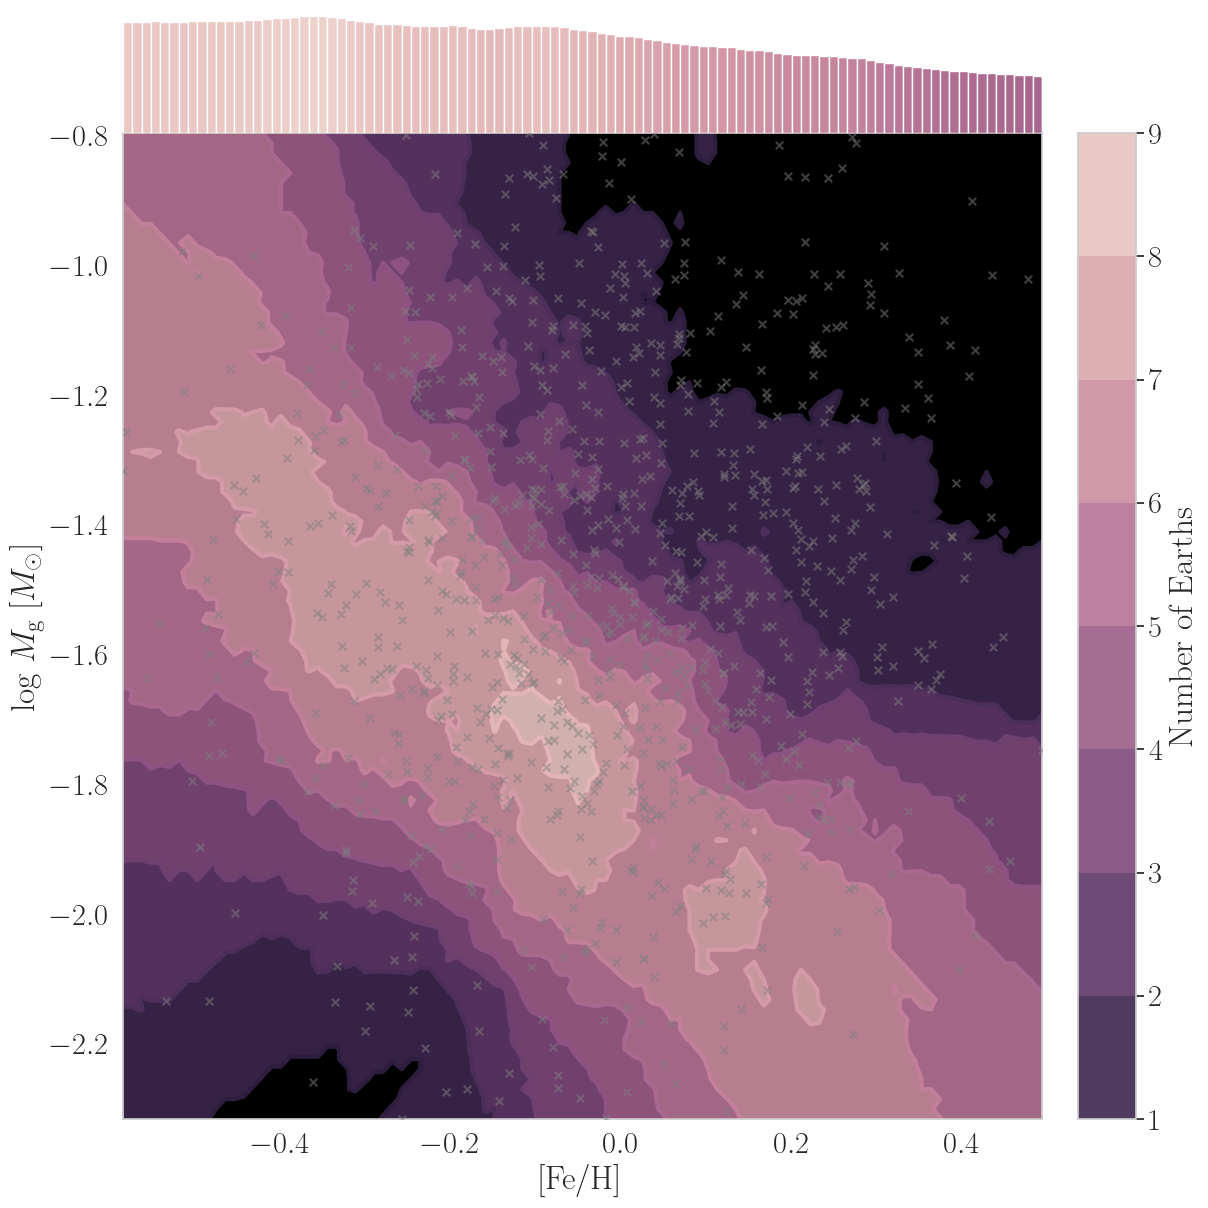

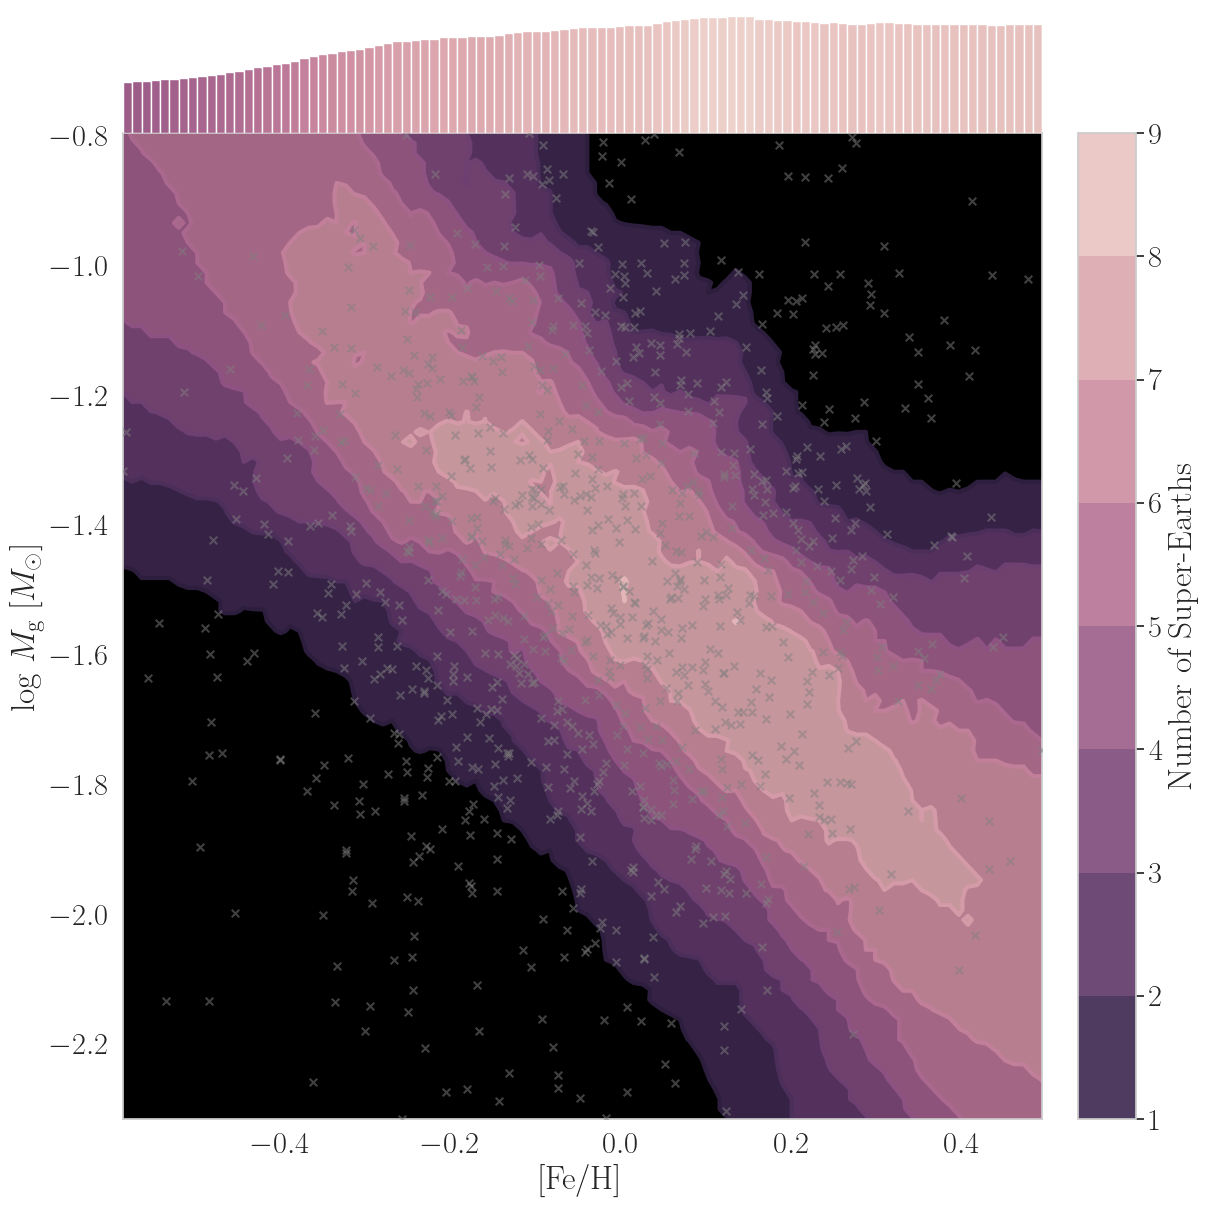

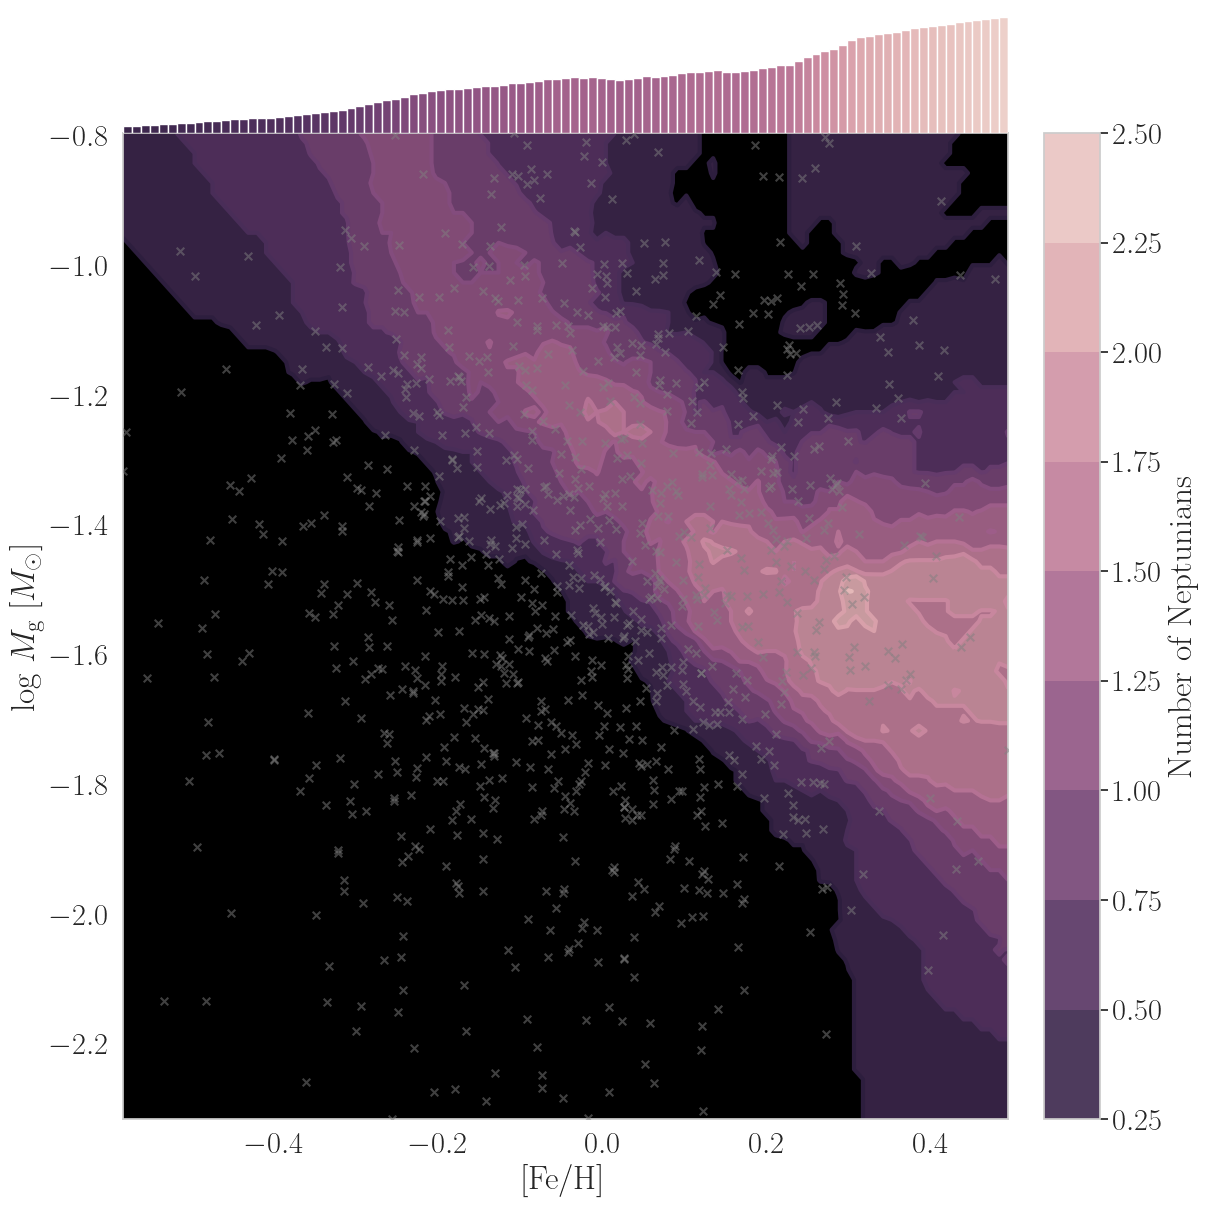

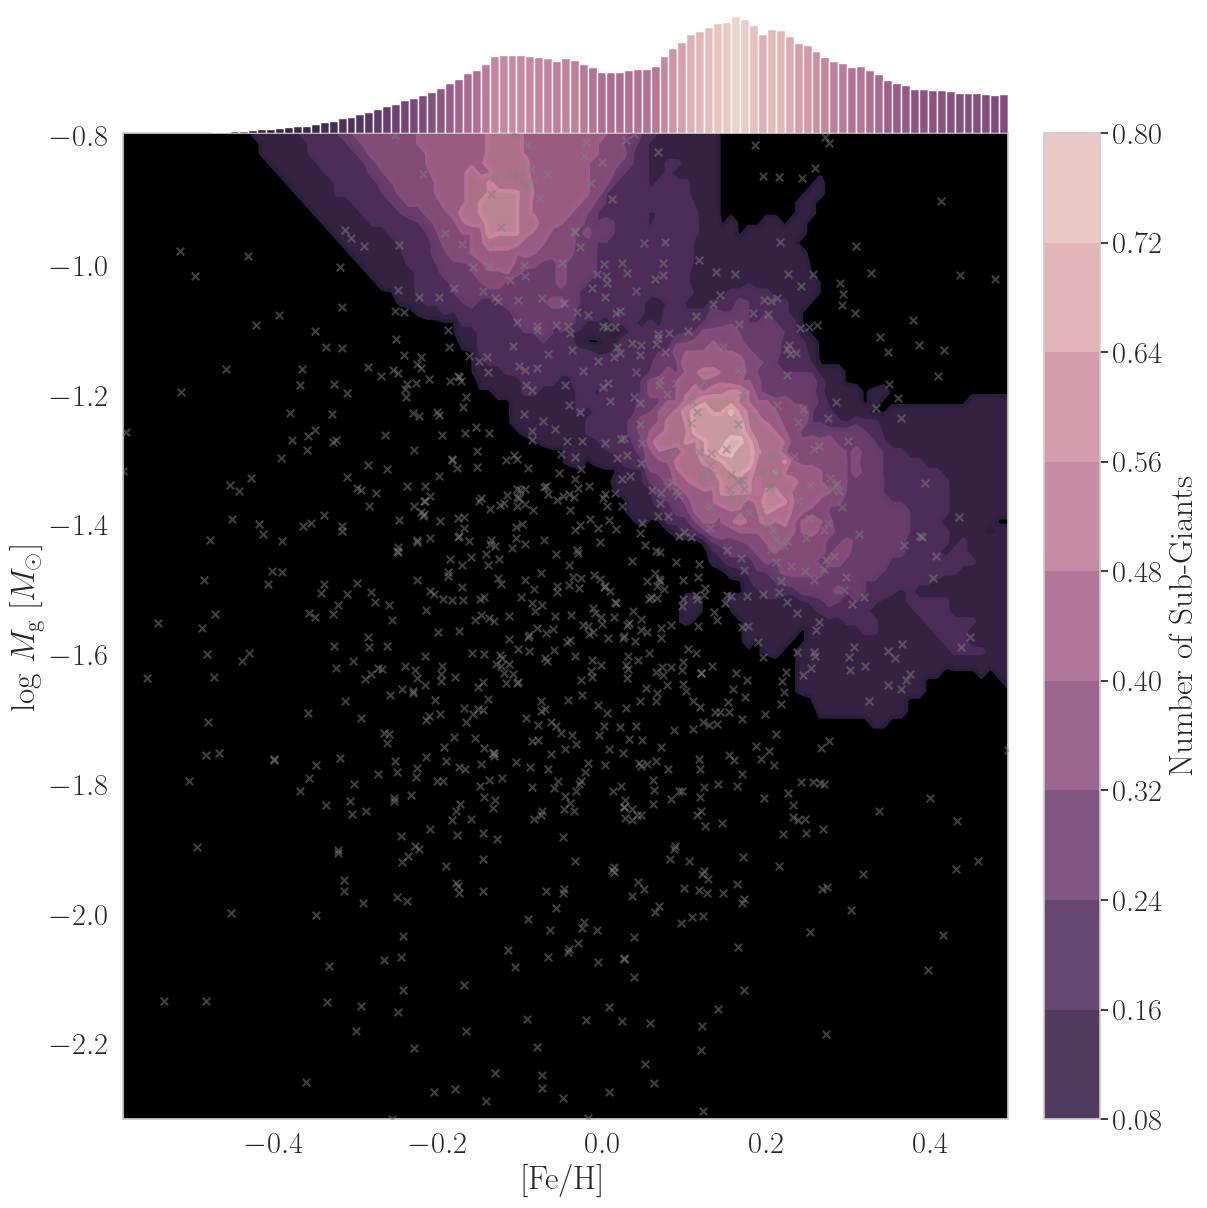

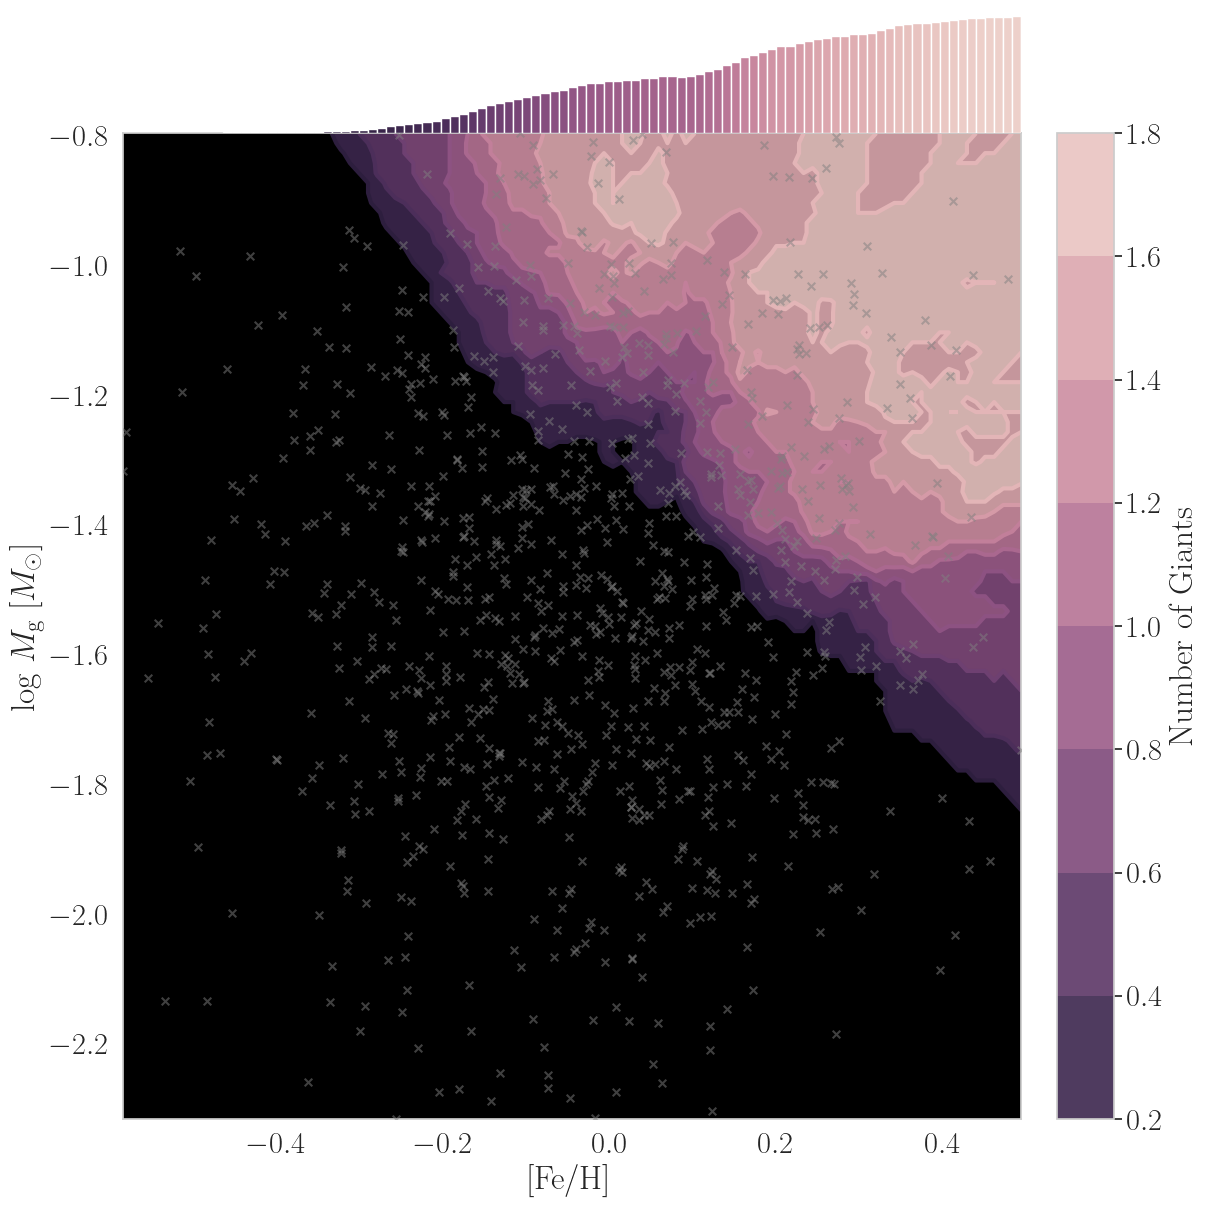

In [62]:
import matplotlib.ticker as ticker

for category in categories:
    contourplot, axes = contour_plot(
        data=grid_results,
        x=variable_labels[0],
        y=variable_labels[1],
        hue=category,
        reshaping_bins=num_bins,
        cmap=get_palette(reverse=True, as_cmap=True),
        colorbar_label=f"Number of {category}s",
        square_aspect_ratio=True,
        outline=True,
        prune_lowest=True,
        kws={"alpha": 0.9},
        okws={"linewidths": 3},
    )

    # add locations of original sample
    axes[0].scatter(
        x=original_sample["[Fe/H]"],
        y=original_sample["log_initial_mass"],
        color="grey",
        marker="x",
        alpha=0.5,
        s=30,
        zorder=10,
    )
    FigureProcessor(contourplot.figure).save(
        f"contourplot_{category}.pdf", sub_directory=figure_directory
    )

In [14]:
sns.kdeplot(
    data=grid_results,
    x=variable_labels[1],
    hue=categories,
)

ValueError: Length of list vectors must match length of `data` when both are used, but `data` has length 10000 and the vector passed to `hue` has length 5.

In [ ]:
grid_results